# Regularized Regression

In [ ]:
###########################################################################
#
#  Copyright 2021 Google Inc.
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      https://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
# This solution, including any related sample code or data, is made available
# on an “as is,” “as available,” and “with all faults” basis, solely for
# illustrative purposes, and without warranty or representation of any kind.
# This solution is experimental, unsupported and provided solely for your
# convenience. Your use of it is subject to your agreements with Google, as
# applicable, and may constitute a beta feature as defined under those
# agreements.  To the extent that you make any data available to Google in
# connection with your use of the solution, you represent and warrant that you
# have all necessary and appropriate rights, consents and permissions to permit
# Google to use and process that data.  By using any portion of this solution,
# you acknowledge, assume and accept all risks, known and unknown, associated
# with its usage, including with respect to your deployment of any portion of
# this solution in your systems, or usage in connection with your business,
# if at all.
###########################################################################

## 0) Dependencies

In [222]:
################################################################################
######################### CHANGE BQ PROJECT NAME BELOW #########################
################################################################################

project_name = 'OnStar_RBA_0708' #add proj name and dataset

In [223]:
# Calculating Relative Importance
!pip install relativeImp
!pip install shap

In [224]:
# Google credentials authentication libraries
from google.colab import auth
auth.authenticate_user()

# data processing libraries
import numpy as np
from numpy.core.numeric import NaN
import pandas as pd
import pandas_gbq
import datetime

# modeling and metrics
from scipy.optimize import least_squares
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut, KFold, LeavePOut
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from statsmodels.stats.stattools import durbin_watson
from sklearn.model_selection import TimeSeriesSplit

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Calculating Relative Importance
from relativeImp import relativeImp
import shap

# BigQuery Magics
'''
BigQuery magics are used to run BigQuery SQL queries in a python environment.
These queries can also be run in the BigQuery UI
'''

from google.cloud import bigquery
from google.cloud.bigquery import magics


from google.colab import files


magics.context.project = project_name  #update your project name

client = bigquery.Client(project=magics.context.project)
%load_ext google.cloud.bigquery
bigquery.USE_LEGACY_SQL = False

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


## 1) Import dataset

In [ ]:
################################################################################
######################### CHANGE BQ PROJECT NAME BELOW #########################
################################################################################

In [ ]:
# %%bigquery df
# SELECT *
# FROM `.RBA_demo.cleaned_data`
# ORDER BY date; #update with project name.

In [320]:
#update file name
#file_name = 'https://raw.githubusercontent.com/zzWIInTer/zz_onstar_rba/master/final_cleaned_data_0708.csv'
#file_name = 'https://raw.githubusercontent.com/zzWIInTer/zz_onstar_rba/master/FY2024_final_cleaned_data_0725.csv'
#file_name = 'https://raw.githubusercontent.com/zzWIInTer/zz_onstar_rba/master/final_cleaned_data_08262024.csv'
file_name = 'https://raw.githubusercontent.com/zzWIInTer/zz_onstar_rba/master/FY2024_final_cleaned_data_08262024.csv'
df_raw = pd.read_csv(file_name)
df_raw.fillna(0, inplace=True)

df=df_raw.copy()
df=df.drop(columns=['DIV_WYG_PPl21_0p0_0d0_0'],axis=1).copy()

#df = df.drop(columns = ['DIV_PKG_SS_ROADSIDEl21_0p0_0d0_0','DIV_PKG_SS_CRASHl21_0p0_0d0_06'])
#df = df.drop(columns = ['DIV_PKG_SS_ROADSIDEl21_0p0_0d0_0','DIV_PKG_SS_CRASHl21_0p0_0d0_06', 'C_PP_PKG_REMOTEl21_0p0_0d0_0'])

df.head()


,Date,A_OC_GOOGLE_SHOPPING,Is_NYE,C_DIV_BUY_CONNECTEDl21_0p0_0d0_0,C_DIV_BUY_ESSENTIALSl21_0p0_0d0_12,C_DIV_BUY_PREMIUMl21_0p0_0d0_0,C_DIV_BUY_SSl21_0p0_0d0_06,C_DIV_CONN_DATAl21_0p0_0d0_06,C_DIV_CONN_REMOTEl21_0p0_0d0_12,C_DIV_CONN_TRYl21_0p0_0d0_12,...,DIV_PKG_SS_ROADSIDEl21_0p0_0d0_06,DIV_PLANPAGE_CONNl21_0p0_0d0_0,DIV_PLANPAGE_ESSl21_0p0_0d0_06,DIV_PLANPAGE_HOMEl21_0p0_0d0_12,OC_APP_Accessl21_0p0_0d0_06,OC_PAGE_ESSl21_0p0_0d0_0,OC_PAGE_PREFl21_0p0_0d0_06,OC_PAGE_PREMl21_0p0_0d0_06,SC_BUYNOWl21_0p0_0d0_12,SC_SHOPNOWl21_0p0_0d0_06
0,1/1/2024,354,1.0,-1.828030,-2.526448,-2.104763,-2.063396,-0.729938,-1.250854,-1.956002,...,0.803995,-2.219101,-1.762813,-1.998409,-2.932118,-0.948632,-2.519696,-1.567837,-0.172139,-0.314432
1,1/2/2024,1151,0.0,-1.498295,-1.701873,-1.692545,-1.611430,0.193948,-1.511079,-1.263386,...,1.806110,-0.652023,0.663929,-0.551123,-0.204862,3.622656,-1.369898,-0.598367,-0.881182,-1.108435
2,1/3/2024,1259,0.0,-1.278471,-0.686296,-0.661999,-1.714378,-1.520723,0.331041,-0.917079,...,1.485304,-0.090557,0.328018,-0.065951,-0.331250,0.567805,-1.168232,-0.461871,-0.172139,-0.314432
3,1/4/2024,1210,0.0,-0.893780,-1.040351,-1.417733,-0.717541,-0.060512,-0.983781,0.512837,...,1.266069,-0.392240,0.263726,-0.283491,-0.842920,-0.054887,-1.077934,-0.663535,-0.881182,-0.263751
4,1/5/2024,1200,0.0,-0.564044,-2.027976,-1.692545,-0.782825,-0.358035,1.056933,-0.436717,...,1.361560,-0.140838,0.887628,-0.435376,-0.799820,-0.186751,-1.401366,-0.568137,3.856514,0.580933


In [198]:
#df.head()

### 1.1) Define KPI column and feature set

In [321]:
date_col = 'Date' #@param {type:"string"}
df = df.drop(columns = [date_col]) # drop date column since it's not part of the feature set

KPI_COL = "A_OC_GOOGLE_SHOPPING" #@param {type:"string"}
y = df[KPI_COL]
X = df[df.columns[df.columns != KPI_COL]].values

## 2) Build RBA Model

Create a linear model to measure the impact of digital media (x variables) on conversions (y variable).

Different regularization techniques, such as Ridge or Lasso, can be implemented to adjust for highly correlated features.

### 2.1) Run the model and print evaluation metrics

In [322]:
train_test_split = 'N'
test_size = 0.1 #@param {type:"number"}

#### 2.1A) Ridge Regression:

In [257]:
# if train_test_split == 'Y':

#   # separate data into train and test based on fraction of test size
#   train_df = df[:round(len(df.index)*(1-test_size))]
#   test_df = df[round(len(df.index)*(1-test_size)):]

#   # split train and test into x/y columns
#   train_x = train_df[train_df.columns[train_df.columns != KPI_COL]].values
#   test_x = test_df[test_df.columns[test_df.columns != KPI_COL]].values

#   train_y = train_df[KPI_COL]
#   test_y = test_df[KPI_COL]

#   # run the model on the training data
#   reg = Ridge().fit(train_x,train_y)

#   # eval metrics - r-squared on training data
#   print('Training Rsquared: ' , round(reg.score(train_x,train_y),2))
#   print('Test Rsquared: ' , round(reg.score(test_x,test_y),2))

#   # Generate predictions to calculate MAE, MSE, RMSE
#   Y_prediction = reg.predict(test_x)
#   print('MAE: ' , round(mean_absolute_error(test_y,Y_prediction),2))
#   print('MSE: ', round(mean_squared_error(test_y,Y_prediction),2))
#   print('RMSE: ',round(np.sqrt(mean_squared_error(test_y,Y_prediction)),2))

# else:
#   # run the model on the full dataset
#   reg = Ridge().fit(X,y)

#   # Generate predictions to calculate residuals
#   Y_prediction = reg.predict(X)

#   # eval metrics - r-squared on full dataset
#   print('R-squared: ',round(reg.score(X,y),5))

In [284]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge
import numpy as np

# Fit the Ridge model

#ridge_reg = Ridge(alpha=1.0)  # You can adjust the alpha value as needed
ridge_reg = Ridge(alpha=100.0)  # Based on CV optimization

ridge_reg.fit(X, y)
reg_optimal_alpha_ridge = ridge_reg.fit(X, y)

# Predict and calculate R-squared
y_pred = ridge_reg.predict(X)
r_squared = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)

print(f'R-squared: {r_squared}')
print(f'Mean Squared Error: {mse}')

# Assuming 'train_x' is a DataFrame or you have access to the original DataFrame's column names

dt_X = df[df.columns[df.columns != KPI_COL]]
feature_names = dt_X.columns  # Replace with  DataFrame's columns if 'train_x' is not a DataFrame

# Getting the coefficients from the Ridge model
coefficients = ridge_reg.coef_

# Pairing each feature name with its corresponding coefficient
for feature, coeff in zip(feature_names, coefficients):
    print(f'{feature}: {coeff}')

# Also printing the intercept
print('Intercept:', ridge_reg.intercept_)




R-squared: 0.6902788572217311
Mean Squared Error: 18491.98381930317
Is_NYE: -3.429559507348444
C_DIV_BUY_CONNECTEDl21_0p0_0d0_0: -6.694953444243077
C_DIV_BUY_ESSENTIALSl21_0p0_0d0_12: -2.92264167883997
C_DIV_BUY_PREMIUMl21_0p0_0d0_0: -2.8244457806591963
C_DIV_BUY_SSl21_0p0_0d0_06: -5.141334829250552
C_DIV_CONN_DATAl21_0p0_0d0_06: 9.691125982720385
C_DIV_CONN_REMOTEl21_0p0_0d0_12: 21.66911599384731
C_DIV_CONN_TRYl21_0p0_0d0_12: -3.237383870568399
C_DIV_GETNOW_CONNl21_0p0_0d0_12: 13.605374569102567
C_DIV_GETNOW_ESSl21_0p0_0d0_06: 11.981829783626749
C_DIV_GETNOW_PREMl21_0p0_0d0_06: 18.74738290639194
C_DIV_GETNOW_SSl21_0p0_0d0_12: -19.079223546333736
C_PP_PKG_APP_ACCESSl21_0p0_0d0_06: -5.031601580184802
C_PP_PKG_CONNECTEDl21_0p0_0d0_0: 3.027803680000145
C_PP_PKG_ESSl21_0p0_0d0_12: 15.289530595733384
C_PP_PKG_PREMl21_0p0_0d0_0: 4.514038435908483
C_PP_PKG_REMOTEl21_0p0_0d0_0: 51.87172243689914
C_PP_PKG_SCl21_0p0_0d0_06: 1.3253714656043494
C_PP_PKG_SSl21_0p0_0d0_12: -5.329229422200384
DIV_GMO

#### 2.1B) Lasso Regression:

In [259]:
# from sklearn.linear_model import Lasso
# from sklearn.metrics import mean_absolute_error, mean_squared_error
# import numpy as np

# if train_test_split == 'Y':

#     # separate data into train and test based on fraction of test size
#     train_df = df[:round(len(df.index)*(1-test_size))]
#     test_df = df[round(len(df.index)*(1-test_size)):]

#     # split train and test into x/y columns
#     train_x = train_df[train_df.columns[train_df.columns != KPI_COL]].values
#     test_x = test_df[test_df.columns[test_df.columns != KPI_COL]].values

#     train_y = train_df[KPI_COL]
#     test_y = test_df[KPI_COL]

#     # run the model on the training data
#     reg = Lasso().fit(train_x, train_y)

#     # eval metrics - r-squared on training data
#     print('Training Rsquared: ', round(reg.score(train_x, train_y), 2))
#     print('Test Rsquared: ', round(reg.score(test_x, test_y), 2))

#     # Generate predictions to calculate MAE, MSE, RMSE
#     Y_prediction = reg.predict(test_x)
#     print('MAE: ', round(mean_absolute_error(test_y, Y_prediction), 2))
#     print('MSE: ', round(mean_squared_error(test_y, Y_prediction), 2))
#     print('RMSE: ', round(np.sqrt(mean_squared_error(test_y, Y_prediction)), 2))

# else:
#     # run the model on the full dataset
#     reg = Lasso().fit(X, y)

#     # Generate predictions to calculate residuals
#     Y_prediction = reg.predict(X)

#     # eval metrics - r-squared on full dataset
#     print('R-squared: ', round(reg.score(X, y), 5))

In [323]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Lasso
import numpy as np

# Fit the Lasso model

#lasso_reg = Lasso(alpha=1.0)  # You can adjust the alpha value as needed
lasso_reg = Lasso(alpha=10.0)  # Set Alpha = 10 based on CV optimization

lasso_reg.fit(X, y)

reg_optimal_alpha_lasso = lasso_reg.fit(X, y)


# Predict and calculate R-squared
y_pred = lasso_reg.predict(X)
r_squared = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)

print(f'R-squared: {r_squared}')
print(f'Mean Squared Error: {mse}')

# Assuming 'train_x' is a DataFrame or you have access to the original DataFrame's column names

dt_X = df[df.columns[df.columns != KPI_COL]]
feature_names = dt_X.columns  # Replace with DataFrame's columns if 'train_x' is not a DataFrame

# Getting the coefficients from the Lasso model
coefficients = lasso_reg.coef_

# Pairing each feature name with its corresponding coefficient
for feature, coeff in zip(feature_names, coefficients):
    print(f'{feature}: {coeff}')

# Also printing the intercept
print('Intercept:', lasso_reg.intercept_)

R-squared: 0.7359050705787726
Mean Squared Error: 15767.858525285024
Is_NYE: -0.0
C_DIV_BUY_CONNECTEDl21_0p0_0d0_0: -0.0
C_DIV_BUY_ESSENTIALSl21_0p0_0d0_12: 0.0
C_DIV_BUY_PREMIUMl21_0p0_0d0_0: 0.0
C_DIV_BUY_SSl21_0p0_0d0_06: -0.0
C_DIV_CONN_DATAl21_0p0_0d0_06: 10.479999280490945
C_DIV_CONN_REMOTEl21_0p0_0d0_12: 0.0
C_DIV_CONN_TRYl21_0p0_0d0_12: -0.0
C_DIV_GETNOW_CONNl21_0p0_0d0_12: 30.057383741251925
C_DIV_GETNOW_ESSl21_0p0_0d0_06: 0.0
C_DIV_GETNOW_PREMl21_0p0_0d0_06: 3.60587994418391
C_DIV_GETNOW_SSl21_0p0_0d0_12: -0.0
C_PP_PKG_APP_ACCESSl21_0p0_0d0_06: -0.0
C_PP_PKG_CONNECTEDl21_0p0_0d0_0: 0.012538760513169035
C_PP_PKG_ESSl21_0p0_0d0_12: 0.0
C_PP_PKG_PREMl21_0p0_0d0_0: 0.0
C_PP_PKG_REMOTEl21_0p0_0d0_0: 150.6793756917052
C_PP_PKG_SCl21_0p0_0d0_06: -0.0
C_PP_PKG_SSl21_0p0_0d0_12: -0.0
DIV_GMOC_SHOP_ESSl21_0p0_0d0_0: -0.0
DIV_GMOC_SHOP_SSl21_0p0_0d0_0: 0.0
DIV_PKG_SS_ROADSIDEl21_0p0_0d0_06: 40.3500800112439
DIV_PLANPAGE_CONNl21_0p0_0d0_0: 0.0
DIV_PLANPAGE_ESSl21_0p0_0d0_06: 0.0
DIV_PLAN

*italicized text*
### 2.2) Cross-validation

In [303]:
cross_val = 'Y' #@param {type:"string"}

#### 2.2A) Cross-validation - Original Code

In [141]:
# if cross_val == 'Y':
#   tscv = TimeSeriesSplit(n_splits = 5)

#   # get number of splits
#   print('Number of splits: ',tscv.get_n_splits())

#   #### Compute average test sets score: ####
#   scores = []

#   for train_index, test_index in tscv.split(df):
#     train_x = df[:len(train_index)].drop(columns = [KPI_COL])
#     #train_y = df.y1[:len(train_index)]
#     train_y = df[KPI_COL][:len(train_index)]

#     test_x = df[len(train_index):len(train_index)+len(test_index)].drop(columns = [KPI_COL])
#     #test_y = df.y1[len(train_index):len(train_index)+len(test_index)]
#     test_y = df[KPI_COL][len(train_index):len(train_index)+len(test_index)]

#     cv_model = Ridge()
#     cv_model.fit(train_x,train_y)

#     preds = cv_model.predict(test_x)

#     # r-squared for the current fold only
#     r2score = cv_model.score(test_x,test_y)
#     scores.append(round(r2score,2))
#     print('Score: ', scores)
#     cv_score = np.mean(scores)
#     print('CV Score: ',round(cv_score,2))

Number of splits:  5
Score:  [0.89]
CV Score:  0.89
Score:  [0.89, -1.78]
CV Score:  -0.44
Score:  [0.89, -1.78, -1.1]
CV Score:  -0.66
Score:  [0.89, -1.78, -1.1, -3.9]
CV Score:  -1.47
Score:  [0.89, -1.78, -1.1, -3.9, 0.26]
CV Score:  -1.13


#### 2.2B) CV - Optimize Alpha - Ridge

In [262]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

if cross_val == 'Y':
    tscv = TimeSeriesSplit(n_splits=5)
    print('Number of splits:', tscv.get_n_splits())

    # Define a range of alpha values to test
    alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    #alphas = [0.01, 0.1, 1, 10, 100]

    best_alpha = None
    best_score = -np.inf

    for alpha in alphas:
        scores = []

        for train_index, test_index in tscv.split(df):
            train_x = df[:len(train_index)].drop(columns=[KPI_COL])
            train_y = df[KPI_COL][:len(train_index)]

            test_x = df[len(train_index):len(train_index)+len(test_index)].drop(columns=[KPI_COL])
            test_y = df[KPI_COL][len(train_index):len(train_index)+len(test_index)]

            ## Use cross validation Train and Predict
            cv_model = Ridge(alpha=alpha)
            cv_model.fit(train_x, train_y)
            r2score = cv_model.score(test_x, test_y)
            scores.append(r2score)

            ## Use cross validation on All Dataset, but different weight
            # cv_model = Ridge(alpha=alpha)
            # cv_model.fit(X, y)
            # r2score = cv_model.score(X, y)
            # scores.append(r2score)

        cv_score = np.mean(scores)
        print(f'Alpha: {alpha}, CV Score Mean: {round(cv_score, 4)}')

        if cv_score > best_score:
            best_score = cv_score
            best_alpha = alpha

    print(f'\nBest Alpha: {best_alpha}')
    print(f'Best CV Score: {round(best_score, 4)}')

    # Use the best alpha for the final model
    final_model = Ridge(alpha=best_alpha)
    final_model.fit(df.drop(columns=[KPI_COL]), df[KPI_COL])

    # You can now use final_model for predictions or further analysis

Number of splits: 5
Alpha: 0.001, CV Score Mean: -4.2326
Alpha: 0.01, CV Score Mean: -4.0888
Alpha: 0.1, CV Score Mean: -3.1056
Alpha: 1, CV Score Mean: -1.4488
Alpha: 10, CV Score Mean: -0.7176
Alpha: 100, CV Score Mean: -0.4296
Alpha: 1000, CV Score Mean: -1.0697

Best Alpha: 100
Best CV Score: -0.4296


#### 2.2C) CV - Optimize Alpha - Lasso

In [304]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

if cross_val == 'Y':
    tscv = TimeSeriesSplit(n_splits=5)
    print('Number of splits: ', tscv.get_n_splits())

    # Define a range of alpha values to test
    alphas = [0.001, 0.01, 0.1, 1, 10, 100]

    best_alpha = None
    best_score = -np.inf

    for alpha in alphas:
        scores = []

        for train_index, test_index in tscv.split(df):
            train_x = df[:len(train_index)].drop(columns=[KPI_COL])
            train_y = df[KPI_COL][:len(train_index)]

            test_x = df[len(train_index):len(train_index)+len(test_index)].drop(columns=[KPI_COL])
            test_y = df[KPI_COL][len(train_index):len(train_index)+len(test_index)]

            cv_model = Lasso(alpha=alpha)
            cv_model.fit(train_x, train_y)

            # r-squared for the current fold
            r2score = cv_model.score(test_x, test_y)
            scores.append(r2score)

        cv_score = np.mean(scores)
        print(f'Alpha: {alpha}, CV Scorec Mean: {round(cv_score, 4)}')

        if cv_score > best_score:
            best_score = cv_score
            best_alpha = alpha

    print(f'\nBest Alpha: {best_alpha}')
    print(f'Best CV Score: {round(best_score, 4)}')

    # Now use the best alpha for the final model
    final_model = Lasso(alpha=best_alpha)
    final_model.fit(df.drop(columns=[KPI_COL]), df[KPI_COL])

    # You can now use final_model for predictions or further analysis

Number of splits:  5
Alpha: 0.001, CV Scorec Mean: -3.3613
Alpha: 0.01, CV Scorec Mean: -3.5288
Alpha: 0.1, CV Scorec Mean: -3.399
Alpha: 1, CV Scorec Mean: -2.1373
Alpha: 10, CV Scorec Mean: -0.3107
Alpha: 100, CV Scorec Mean: -0.3124

Best Alpha: 10
Best CV Score: -0.3107


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.072e+02, tolerance: 2.489e+02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.870e+03, tolerance: 2.489e+02
  model = cd_fast.enet_coordinate_descent(


## 3) Calculate contribution of each digital tactic

Shap values are a method for interpreting how each feature impacts a model, both locally and globally.

More info can be found [here](https://shap.readthedocs.io/en/latest/index.html)

In [324]:
## Fit the explainer
## Regular, default Alpha = 1.0
#explainer = shap.Explainer(reg.predict,X)

## Using optimized Alpha for Ridge
#explainer = shap.Explainer(reg_optimal_alpha_ridge.predict,X)

## Using optimized Alpha for Lasso
explainer = shap.Explainer(reg_optimal_alpha_lasso.predict,X)

## Calculate the shap values
shap_values = explainer(X)

In [119]:
## shap values
#shap.plots.bar(shap_values,max_display = len(df[df.columns[df.columns != KPI_COL]].columns))

In [325]:
vals= np.abs(shap_values.values).mean(axis = 0)

feature_importance = pd.DataFrame(list(zip(df[df.columns[df.columns != KPI_COL]].columns, vals)), columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
feature_importance

,col_name,feature_importance_vals
16,C_PP_PKG_REMOTEl21_0p0_0d0_0,104.355517
21,DIV_PKG_SS_ROADSIDEl21_0p0_0d0_06,37.233140
25,OC_APP_Accessl21_0p0_0d0_06,33.411900
8,C_DIV_GETNOW_CONNl21_0p0_0d0_12,22.069439
26,OC_PAGE_ESSl21_0p0_0d0_0,19.930826
24,DIV_PLANPAGE_HOMEl21_0p0_0d0_12,9.918303
5,C_DIV_CONN_DATAl21_0p0_0d0_06,8.041788
10,C_DIV_GETNOW_PREMl21_0p0_0d0_06,3.206037
28,OC_PAGE_PREMl21_0p0_0d0_06,1.953891
13,C_PP_PKG_CONNECTEDl21_0p0_0d0_0,0.009908


In [326]:
# rescale the shap values to result in a scale rleative to total r-squared

sum_feature_imp = feature_importance.feature_importance_vals.sum()
#scale_factor = reg_optimal_alpha_ridge.score(X,y)

scale_factor = reg_optimal_alpha_lasso.score(X,y)

feature_importance['attribution'] = feature_importance.feature_importance_vals / (sum_feature_imp / scale_factor)
feature_importance

,col_name,feature_importance_vals,attribution
16,C_PP_PKG_REMOTEl21_0p0_0d0_0,104.355517,0.319808
21,DIV_PKG_SS_ROADSIDEl21_0p0_0d0_06,37.233140,0.114105
25,OC_APP_Accessl21_0p0_0d0_06,33.411900,0.102394
8,C_DIV_GETNOW_CONNl21_0p0_0d0_12,22.069439,0.067634
26,OC_PAGE_ESSl21_0p0_0d0_0,19.930826,0.061080
24,DIV_PLANPAGE_HOMEl21_0p0_0d0_12,9.918303,0.030396
5,C_DIV_CONN_DATAl21_0p0_0d0_06,8.041788,0.024645
10,C_DIV_GETNOW_PREMl21_0p0_0d0_06,3.206037,0.009825
28,OC_PAGE_PREMl21_0p0_0d0_06,1.953891,0.005988
13,C_PP_PKG_CONNECTEDl21_0p0_0d0_0,0.009908,0.000030


In [327]:
round(feature_importance.attribution.sum(),5)

0.73591

## 4) Validate Linear Regression Model Assumptions

### 4.1) Generate model residuals

In [328]:
residuals = Y_prediction - y

#Y_prediction
#y

###4.2) Linearity

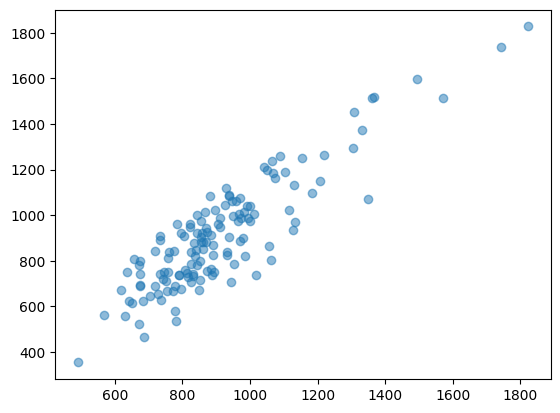

In [329]:
'''
Visually inspect linearity between target variable (y1) and predictions
'''
plt.plot(Y_prediction,y,'o',alpha=0.5)
plt.show()

### 4.3) Normality of Errors

In [272]:
'''
Visually inspect the residuals to confirm normality
'''

'\nVisually inspect the residuals to confirm normality\n'

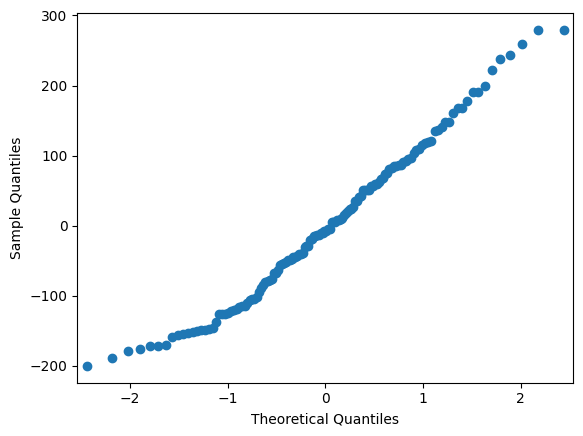

In [330]:
fig = sm.qqplot(residuals)

<ipython-input-331-24786c19d6f5>:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(residuals, label = '', shade = True)


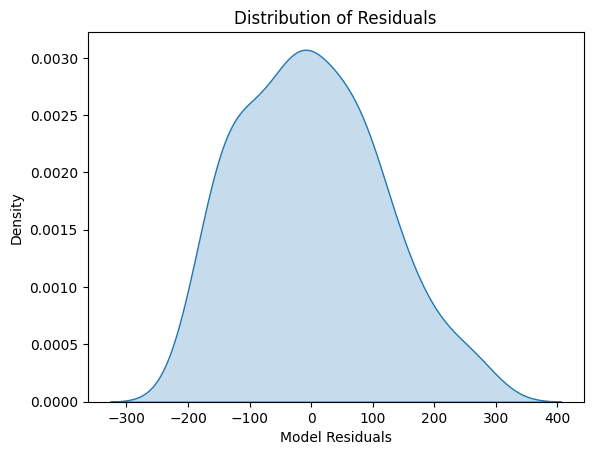

In [331]:
sns.kdeplot(residuals, label = '', shade = True)
plt.xlabel('Model Residuals'); plt.ylabel('Density'); plt.title('Distribution of Residuals');

###4.4) Homoscedasticity


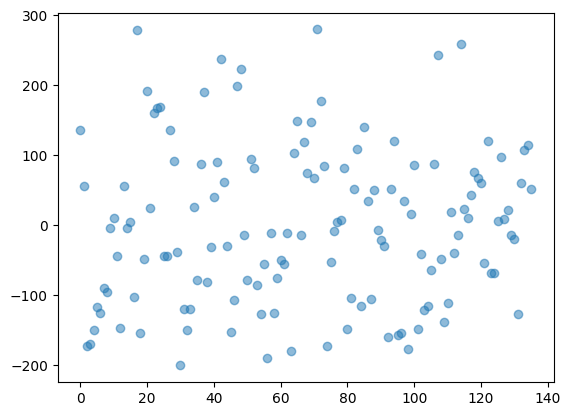

In [332]:
'''
Visually inspect residuals to confirm constant variance
'''
plt.plot(residuals,'o',alpha=0.5)
plt.show()

###4.5) Residual Autocorrelation Check

In [333]:
'''
The Durbin Watson test is a statistical test for detecting autocorrelation of the
model residuals
'''

dw = durbin_watson(residuals)
print('Durbin-Watson',dw)

Durbin-Watson 1.5163028301279748


In [334]:
if dw < 1.5:
        print('Positive autocorrelation', '\n')
elif dw > 2.5:
        print('Negative autocorrelation', '\n')
else:
        print('Little to no autocorrelation', '\n')


Little to no autocorrelation 



In [335]:
#df.head()

In [336]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Assuming 'X' is your predictors DataFrame

# Assuming 'df' is your DataFrame with all the predictor variables
#X = df.drop(columns = [KPI_COL, date_col], axis=1)  # Assuming 'y1' is your target variable
X = df.drop(columns = [KPI_COL], axis=1)  # Assuming 'y1' is your target variable

# Add a constant to the model (if it's not already included)
X = sm.add_constant(X)

# Calculate VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)


                               Feature       VIF
0                                const  1.037714
1                               Is_NYE  1.303179
2     C_DIV_BUY_CONNECTEDl21_0p0_0d0_0  4.562606
3   C_DIV_BUY_ESSENTIALSl21_0p0_0d0_12  3.074574
4       C_DIV_BUY_PREMIUMl21_0p0_0d0_0  4.657935
5           C_DIV_BUY_SSl21_0p0_0d0_06  2.760141
6        C_DIV_CONN_DATAl21_0p0_0d0_06  2.111916
7      C_DIV_CONN_REMOTEl21_0p0_0d0_12  2.791793
8         C_DIV_CONN_TRYl21_0p0_0d0_12  1.599392
9      C_DIV_GETNOW_CONNl21_0p0_0d0_12  6.035974
10      C_DIV_GETNOW_ESSl21_0p0_0d0_06  1.973989
11     C_DIV_GETNOW_PREMl21_0p0_0d0_06  3.979414
12       C_DIV_GETNOW_SSl21_0p0_0d0_12  8.237146
13   C_PP_PKG_APP_ACCESSl21_0p0_0d0_06  1.928357
14     C_PP_PKG_CONNECTEDl21_0p0_0d0_0  4.877198
15          C_PP_PKG_ESSl21_0p0_0d0_12  4.836038
16          C_PP_PKG_PREMl21_0p0_0d0_0  5.128016
17        C_PP_PKG_REMOTEl21_0p0_0d0_0  9.938304
18           C_PP_PKG_SCl21_0p0_0d0_06  1.679009
19           C_PP_PK

## 5) Export Final Results

In [337]:
final_results_df = feature_importance[['col_name','feature_importance_vals','attribution']]
final_results_df.to_csv('rba_final_output_Regular_Reg.csv', encoding = 'utf-8-sig')
files.download('rba_final_output_Regular_Reg.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>